<a href="https://colab.research.google.com/github/shadmanshakib09/Rice-Leaf-Disease-Detection/blob/main/Rice_Leaf_disease_detection_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ViT transformer

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:

%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [ ]:
%cd CONFERENCE1

/content/gdrive/.shortcut-targets-by-id/14iSH-uYVIsSWIRZ3acFwjZ39HjpSY0kt/CONFERENCE1


In [ ]:
import random
import cv2 as cv
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.applications import InceptionV3


In [ ]:
IMAGE_SIZE = 224
BATCH_SIZE = 16


CHANNELS = 3


In [ ]:
data_dir = '/content/gdrive/MyDrive/CONFERENCE1/train2/'

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 4702 files belonging to 3 classes.


In [ ]:


class_names = dataset.class_names
print(class_names)
print(f'Total length of dataset: {len(dataset)}')

['BACTERIAL BLIGHT', 'BLAST', 'BROWNSPOT']
Total length of dataset: 294


In [ ]:
train_size = 0.8
print(f'Train dataset size: {len(dataset)*train_size}')
train_ds = dataset.take(235)
test_ds = dataset.skip(235)
print(f'Test dataset size: {len(test_ds)}')
val_size = 0.1
# print(len(dataset)*val_size)
val_ds = test_ds.take(30)
print(f'Val dataset size: {len(val_ds)}')
test_ds = test_ds.skip(30)
print(f'Test dataset size: {len(test_ds)}')

Train dataset size: 235.20000000000002
Test dataset size: 59
Val dataset size: 30
Test dataset size: 29


In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = 30
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    print(len(val_ds))
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

30


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [ ]:
epochs = 100
num_classes = 3

In [ ]:
!pip install vit_keras


In [ ]:
pip install tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 7.0 MB/s eta 0:00:00


In [ ]:
from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


347502902/347502902 [==============================] - 2s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import glob, random, os, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()

import warnings
warnings.filterwarnings("ignore")

TensorFlow Version 2.15.0


In [ ]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

In [ ]:
type(train_ds)


tensorflow.python.data.ops.prefetch_op._PrefetchDataset

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


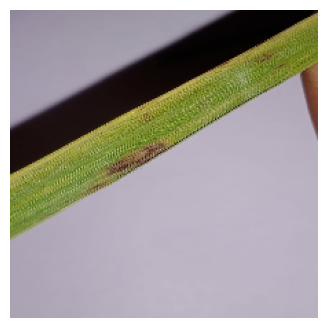

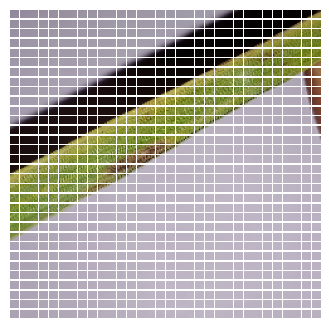

In [ ]:
plt.figure(figsize=(4, 4))
batch_size = 16
patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (IMAGE_SIZE // patch_size) ** 2

for images, labels in train_ds.take(1):
    image = images[0]

plt.imshow(image.numpy().astype('uint8'))
plt.axis('off')

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (IMAGE_SIZE, IMAGE_SIZE)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {IMAGE_SIZE} X {IMAGE_SIZE}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

In [ ]:
model1 = Sequential()
from vit_keras import vit

pretrained_model = vit.vit_b16(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

In [ ]:
for layer in pretrained_model.layers:
    layer.trainable = False
model1.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(224,224, 3)))
model1.add(pretrained_model)
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(128, activation='relu'))
model1.add(layers.Dense(64, activation='relu'))
model1.add(layers.Dense(num_classes, activation='softmax'))
model1.compile(optimizer='adam',
               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])

In [ ]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 256)               196864    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 3)                

In [ ]:
print(len(pretrained_model.layers))

19


In [ ]:
history1 = model1.fit(
train_ds,
validation_data=val_ds,
epochs=epochs
)

Epoch 1/100
235/235 [==============================] - 667s 482ms/step - loss: 0.5768 - accuracy: 0.7609 - val_loss: 0.2171 - val_accuracy: 0.9146
Epoch 2/100
235/235 [==============================] - 71s 304ms/step - loss: 0.2923 - accuracy: 0.8843 - val_loss: 0.1428 - val_accuracy: 0.9500
Epoch 3/100
235/235 [==============================] - 68s 289ms/step - loss: 0.1966 - accuracy: 0.9271 - val_loss: 0.1067 - val_accuracy: 0.9563
Epoch 4/100
235/235 [==============================] - 67s 286ms/step - loss: 0.1575 - accuracy: 0.9362 - val_loss: 0.0540 - val_accuracy: 0.9833
Epoch 5/100
235/235 [==============================] - 67s 286ms/step - loss: 0.1496 - accuracy: 0.9348 - val_loss: 0.0649 - val_accuracy: 0.9729
Epoch 6/100
235/235 [==============================] - 67s 286ms/step - loss: 0.1168 - accuracy: 0.9500 - val_loss: 0.0833 - val_accuracy: 0.9625
Epoch 7/100
235/235 [==============================] - 71s 302ms/step - loss: 0.1107 - accuracy: 0.9505 - val_loss: 0.0523 

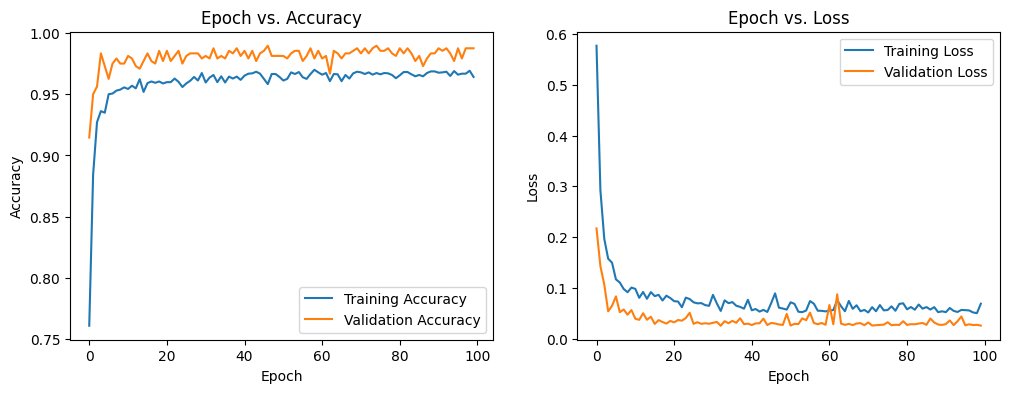

In [ ]:

#Plot epoch vs Accuracy and epoch vs Loss
accuracy = history1.history['accuracy']
val_accuracy = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.plot(range(epochs), accuracy, label='Training Accuracy')
plt.plot(range(epochs), val_accuracy, label='Validation Accuracy')
plt.title('Epoch vs. Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(122)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.title('Epoch vs. Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
scores1 = model1.evaluate(test_ds)
print(scores1)
acc = history1.history['accuracy']
print(acc)
val_acc = history1.history['val_accuracy']
print(val_acc)
loss = history1.history['loss']
print(loss)
val_loss = history1.history['val_loss']
print(val_loss)

29/29 [==============================] - 49s 243ms/step - loss: 0.0441 - accuracy: 0.9612
[0.04408740997314453, 0.9612069129943848]
[0.7609042525291443, 0.8843085169792175, 0.9271276593208313, 0.936170220375061, 0.9348404407501221, 0.949999988079071, 0.9505318999290466, 0.9529255032539368, 0.9537234306335449, 0.9555851221084595, 0.9542553424835205, 0.9569149017333984, 0.9547872543334961, 0.9622340202331543, 0.9518616795539856, 0.9590425491333008, 0.9603723287582397, 0.9593085050582886, 0.9603723287582397, 0.958776593208313, 0.9598404169082642, 0.9598404169082642, 0.9627659320831299, 0.960106372833252, 0.9558510780334473, 0.958776593208313, 0.9609042406082153, 0.9640957713127136, 0.9611701965332031, 0.9672872424125671, 0.9595744609832764, 0.963563859462738, 0.9656915068626404, 0.9598404169082642, 0.9646276831626892, 0.9595744609832764, 0.9643617272377014, 0.9627659320831299, 0.9643617272377014, 0.9617021083831787, 0.9651595950126648, 0.9667553305625916, 0.9670212864875793, 0.96835106611

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 65ms/step


ValueError: num must be an integer with 1 <= num <= 9, not 10

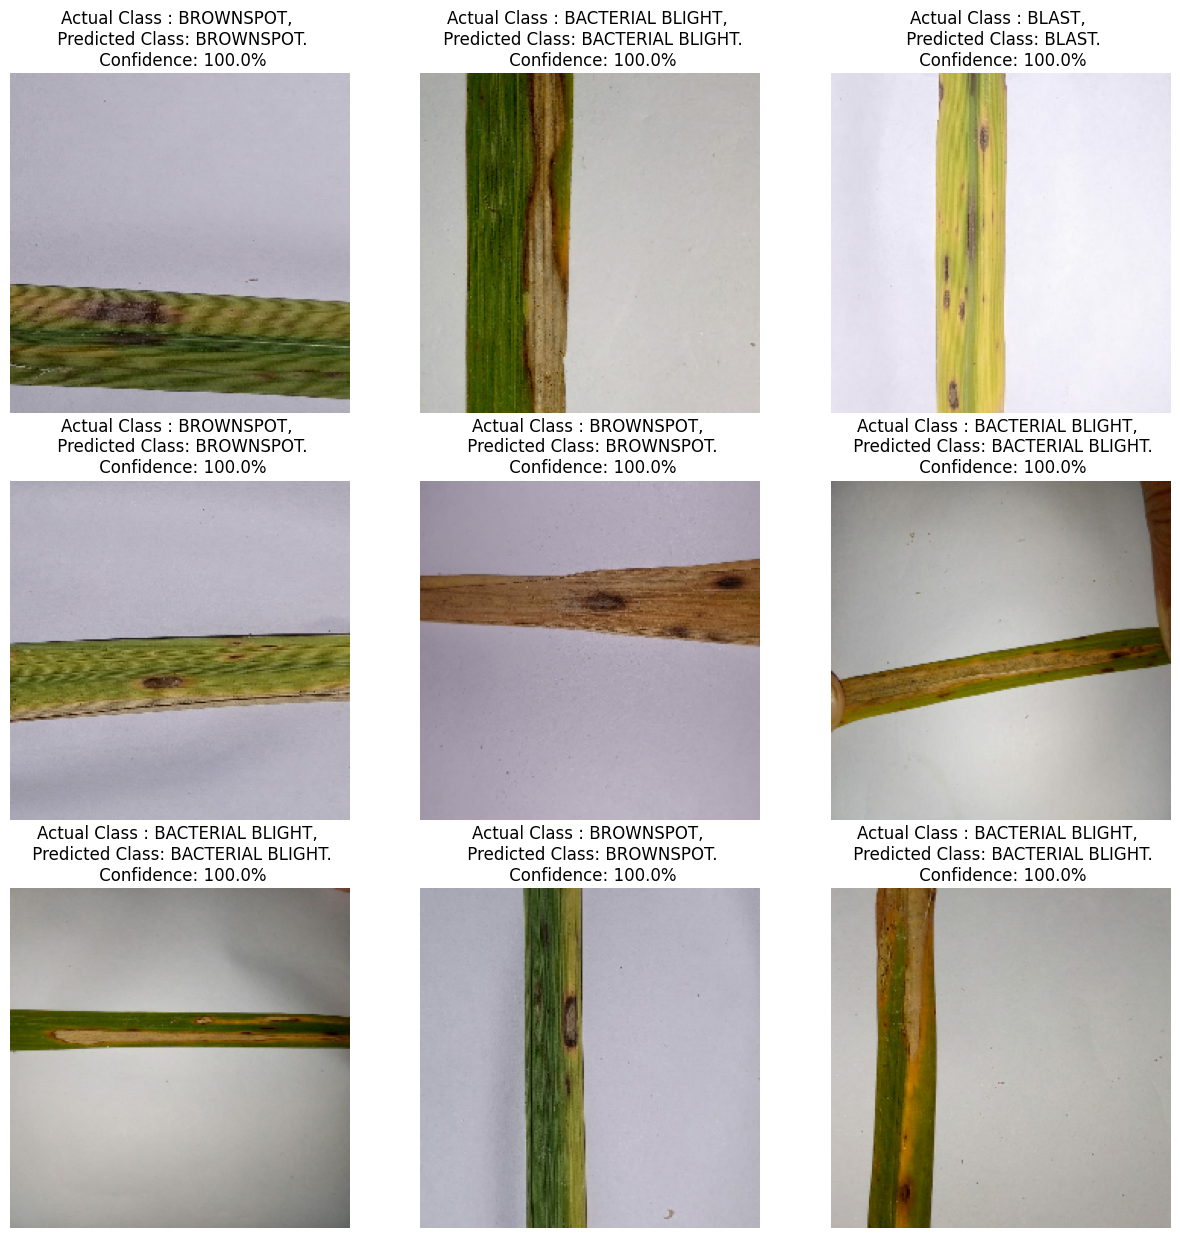

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(BATCH_SIZE):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model1, images[i].numpy())

        actual_class = class_names[labels[i]]

        plt.title(f"Actual Class : {actual_class}, \n Predicted Class: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

for image_batch, label_batch in test_ds:
  y_true.append(label_batch)
  preds = model1.predict(image_batch)
  y_pred.append(np.argmax(preds, axis=-1))

correct_labels = tf.concat([item for item in y_true], axis=0)
predicted_labels = tf.concat([item for item in y_pred], axis=0)
conf_matrix = confusion_matrix(correct_labels, predicted_labels)

1/1 [==============================] - 0s 238ms/step


In [ ]:
print(classification_report( correct_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       139
           1       1.00      0.93      0.97       169
           2       0.92      1.00      0.96       156

    accuracy                           0.96       464
   macro avg       0.96      0.96      0.96       464
weighted avg       0.96      0.96      0.96       464



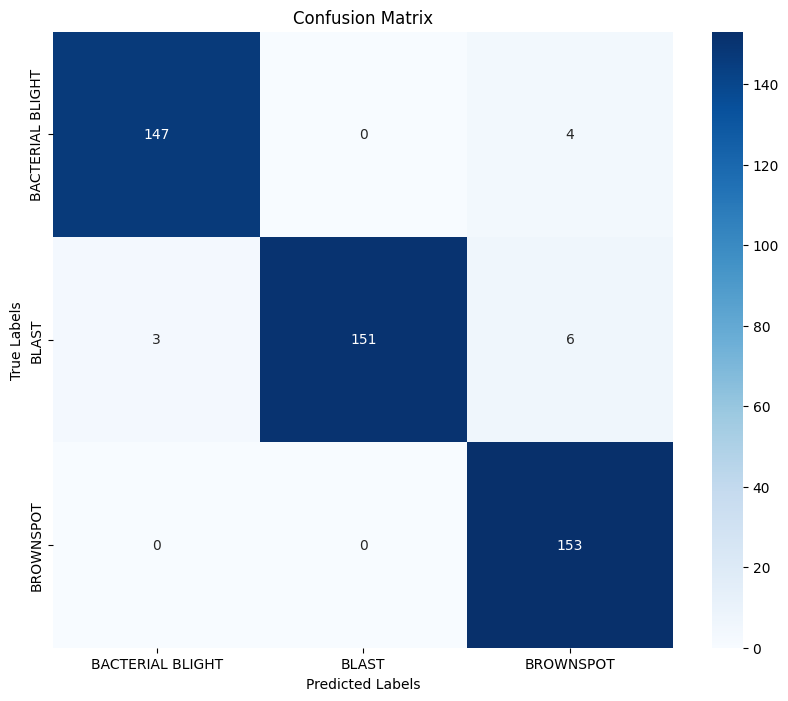

In [ ]:

conf_mat = confusion_matrix(correct_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
print("Mean Absolute Error:" , mean_absolute_error(correct_labels,predicted_labels))

Mean Absolute Error: 0.05387931034482758


In [ ]:
print("Mean Squared Error:" , mean_squared_error(correct_labels,predicted_labels))

Mean Squared Error: 0.08405172413793104


29/29 [==============================] - 10s 240ms/step


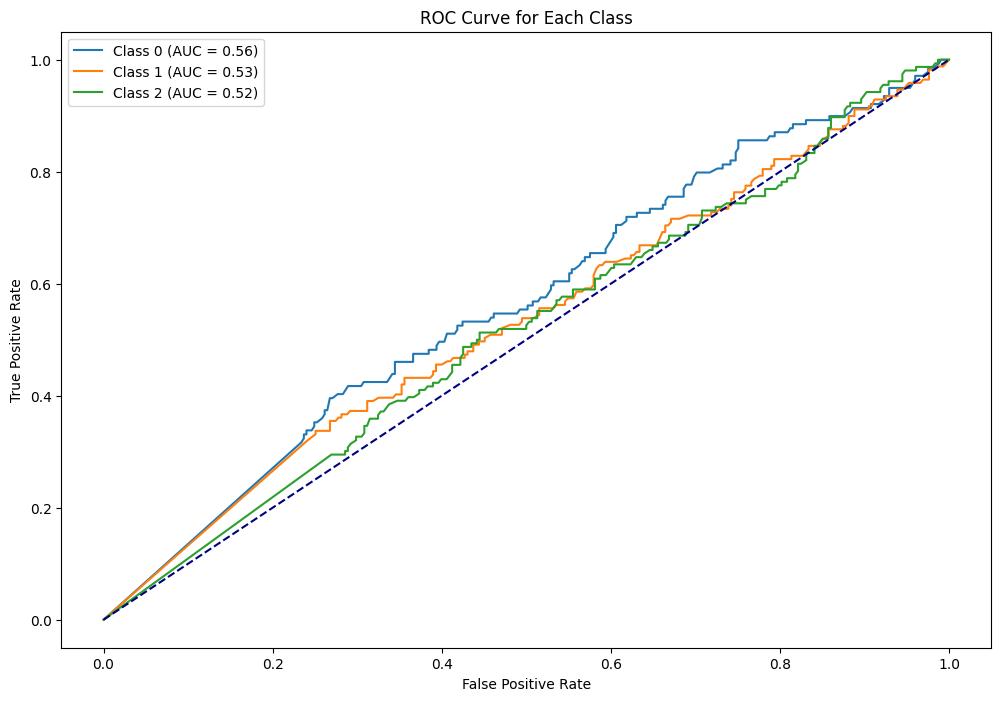

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# ...

# Get predicted probabilities for each class
y_prob = model1.predict(test_ds)

# Convert true labels to one-hot encoding
y_true_one_hot = tf.keras.utils.to_categorical(correct_labels, num_classes=num_classes)

# Calculate AUC for each class
auc_scores = []
for i in range(num_classes):
    auc_score = roc_auc_score(y_true_one_hot[:, i], y_prob[:, i])
    auc_scores.append(auc_score)

# Plot ROC curve for each class
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {auc_scores[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

# ...

# Get predicted probabilities for each class
y_prob = model1.predict(test_ds)

# Convert true labels to one-hot encoding
y_true_one_hot = tf.keras.utils.to_categorical(correct_labels, num_classes=num_classes)

# Calculate micro-average AUC score
micro_auc_score = roc_auc_score(y_true_one_hot, y_prob, average='micro')

# Calculate macro-average AUC score
macro_auc_score = roc_auc_score(y_true_one_hot, y_prob, average='macro')

print(f'Micro-average AUC Score: {micro_auc_score:.4f}')
print(f'Macro-average AUC Score: {macro_auc_score:.4f}')


29/29 [==============================] - 7s 246ms/step
Micro-average AUC Score: 0.5094
Macro-average AUC Score: 0.5076


In [ ]:
pip install folium

In [ ]:
import folium

# Coordinates
latitude = 22.79157021482205
longitude = 91.10269569345805

# Create a map centered at the specified location
map_object = folium.Map(location=[latitude, longitude], zoom_start=15)

# Add a marker at the specified location
folium.Marker(location=[latitude, longitude], popup='Your Location').add_to(map_object)

# Save the map to an HTML file (optional)
map_object.save("map.html")

# Display the map
map_object
